 # Preparation code
 ## Importing related libraries utilized throughout the notebook

In [1]:
import copy
import json
import os
import pathlib
import random
import shutil
import sys
from collections import OrderedDict
from typing import List, Tuple

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm


sys.path.append("/home/dang/storage_1/workspace/tiatoolbox")

# ! save_yaml, save_as_json => need same name, need to factor out jsonify
from tiatoolbox.utils.misc import save_as_json


mpl.rcParams['figure.dpi'] = 160  # for high resolution figure in notebook

 Here we define some quality of life functions that will be frequently reused
 throughout the notebook.
 - `load_json`: Function to load json from path.
 - `rmdir`: Function to remove directory at path.
 - `rm_n_mkdir`: Function to remove and then re-create directory at path.
 This is utilized in cases we want to have fresh set of output at path.
 - `recur_find_ext`: Function to traverse directories under path and return
 list of file paths of the extension we want to search for. This is much faster
 than using `glob`, escpecially in case the directory hierarchy within path is
 complicated and there may be more than 1k files we want to find.

In [2]:
def load_json(path: str):
    """Helper to load json file."""
    with open(path, "r") as fptr:
        json_dict = json.load(fptr)
    return json_dict


def rmdir(dir_path: str):
    """Helper function to remove directory."""
    if os.path.isdir(dir_path):
        shutil.rmtree(dir_path)
    return


def rm_n_mkdir(dir_path: str):
    """Helper function to remove then re-create directory."""
    if os.path.isdir(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)
    return


def recur_find_ext(root_dir: str, exts: List[str]):
    """Helper function to recursively get files with extensions.

    Recursively find all files in directories end with the `ext`
    such as `ext=['.png']` . Much faster than glob if the folder
    hierachy is complicated and contain > 1000 files.

    Args:
        root_dir (str): Root directory for searching.
        exts (list): List of extensions to match.

    Returns:
        List of full paths with matched extension in sorted order.

    """
    assert isinstance(exts, list)
    file_path_list = []
    for cur_path, dir_list, file_list in os.walk(root_dir):
        for file_name in file_list:
            file_ext = pathlib.Path(file_name).suffix
            if file_ext in exts:
                full_path = os.path.join(cur_path, file_name)
                file_path_list.append(full_path)
    file_path_list.sort()
    return file_path_list

 ## Loading affiliated dataset
 We start the main part of the note book by defining and loading
 the affiliated original data. In this case, they are
 - The Whole Slide Images (WSIs), or the paths pointing to them.
 - The associated tissue masks if they are available to reduce
 our subsequent computation when generatin intermediate results.
 - The patient labels, and then the slide labels so to speak for
 our task.

 In the scope of this notebook, our task is classifying if
 a WSI is being HER2 negative or positive. And for this
 dataset, HER2 status is provided per patient instead of per slide.
 As such, for WSIs coming from the same patient, we assign them the
 same label. Besides that, WSIs that do not have labels are also
 excluded from subsequent processing.

 `ROOT_OUTPUT_DIR`: Root directory to save output under.
 `WSI_DIR`: Directory contains WSIs.
 `MSK_DIR`: Directory to retrieve corresponding WSI mask. If set to `None`,
 the subsequent process will use the default method in the toolbox to obtain
 the mask here [@!URL]

In [3]:
SEED = 5
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

ROOT_OUTPUT_DIR = "/home/dang/storage_1/workspace/tiatoolbox/local/code/dump/"
WSI_DIR = "/home/dang/storage_1/dataset/TCGA-LUAD/"
MSK_DIR = None

wsi_paths = recur_find_ext(WSI_DIR, [".svs", ".ndpi"])
wsi_names = [pathlib.Path(v).stem for v in wsi_paths]
msk_paths = None if MSK_DIR is None else [f"{MSK_DIR}/{v}.png" for v in wsi_names]
assert len(wsi_paths) > 0, "No files found."

# !- debug injection, remove later
wsi_paths = recur_find_ext(
    "/home/dang/storage_1/workspace/tiatoolbox/local/code/data/resnet", [".json"]
)
wsi_names = np.array([pathlib.Path(v).stem for v in wsi_paths])
# !-

CLINICAL_FILE = (
    "/home/dang/storage_1/workspace/tiatoolbox/local/code/TCGA-BRCA-DX_CLINI.csv"
)
clinical_df = pd.read_csv(CLINICAL_FILE)

patient_uids = clinical_df["PATIENT"].to_numpy()
patient_labels = clinical_df["HER2FinalStatus"].to_numpy()

patient_labels_ = np.full_like(patient_labels, -1)
patient_labels_[patient_labels == "Positive"] = 1
patient_labels_[patient_labels == "Negative"] = 0
sel = patient_labels_ >= 0

patient_uids = patient_uids[sel]
patient_labels = patient_labels_[sel]
assert len(patient_uids) == len(patient_labels)
clinical_info = OrderedDict(list(zip(patient_uids, patient_labels)))

# retrieve patient code of each WSI, this is basing TCGA bar codes
# https://docs.gdc.cancer.gov/Encyclopedia/pages/TCGA_Barcode/
wsi_patient_codes = np.array(["-".join(v.split("-")[:3]) for v in wsi_names])
wsi_labels = np.array(
    [clinical_info[v] if v in clinical_info else np.nan for v in wsi_patient_codes]
)

 ## Generate the data split
 Now, we start defining how out dataset should be split into training,
 validation, and testing set. To that end, we define a new function called
 `generate_split`. It will receive paired input of the samples and their labels;
 the train, valid, and test percentage; and then return a number of stratified
 splits.

In [4]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit


def generate_split(x, y, train, valid, test, num_folds):
    """Helper to generate stratified splits.

    Split `x` and `y` in to N number of `num_folds` sets
    of `train`, `valid`, and `test` set in stratified manner.
    `train`, `valid`, and `test` are guaranteed to be mutually
    exclusive.

    Args:
        x (list, np.ndarray): List of samples.
        y (list, np.ndarray): List of labels, each value is the value
            of the sample at the same index in `x`.
        train (float): Percentage to be used for training set.
        valid (float): Percentage to be used for validation set.
        test (float): Percentage to be used for testing set.
        num_folds (int): Number of split generated.
    Returns:
        A list of splits where each is a dictionary of
        {
            'train': [(sample_A, label_A), (sample_B, label_B), ...],
            'valid': [(sample_C, label_C), (sample_D, label_D), ...],
            'test' : [(sample_E, label_E), (sample_E, label_E), ...],
        }

    """
    assert train + valid + test - 1.0 < 1.0e-10, "Ratio must be summed up to 1.0 ."

    outer_splitter = StratifiedShuffleSplit(
        n_splits=num_folds,
        train_size=train + valid,
        random_state=SEED
    )
    inner_splitter = StratifiedShuffleSplit(
        n_splits=1,
        train_size=train / (train + valid),
        random_state=SEED,
    )

    x = np.array(x)
    y = np.array(y)
    split_list = []
    for train_valid_idx, test_idx in outer_splitter.split(x, y):
        test_x = x[test_idx]
        test_y = y[test_idx]

        # holder for train_valid set
        x_ = x[train_valid_idx]
        y_ = y[train_valid_idx]

        # split train_valid into train and valid set
        train_idx, valid_idx = list(inner_splitter.split(x_, y_))[0]
        valid_x = x_[valid_idx]
        valid_y = y_[valid_idx]

        train_x = x_[train_idx]
        train_y = y_[train_idx]
        # integrity check
        assert len(set(train_x).intersection(set(valid_x))) == 0
        assert len(set(valid_x).intersection(set(test_x))) == 0
        assert len(set(train_x).intersection(set(test_x))) == 0        

        split_list.append(
            {
                "train": list(zip(train_x, train_y)),
                "valid": list(zip(valid_x, valid_y)),
                "test": list(zip(test_x, test_y)),
            }
        )
    return split_list

 Now, we split the data with given ratio.

 ![@John] do we want to load cached split also? I think we should

In [5]:
# !- debug injection, remove later
wsi_paths = recur_find_ext(
    "/home/dang/storage_1/workspace/tiatoolbox/local/code/data/resnet", [".json"]
)
wsi_names = np.array([pathlib.Path(v).stem for v in wsi_paths])
# !-

NUM_FOLDS = 5
TEST_RATIO = 0.2
TRAIN_RATIO = 0.8 * 0.9
VALID_RATIO = 0.8 * 0.1

sel = ~np.isnan(wsi_labels)
wsi_labels = wsi_labels[sel]
wsi_names = wsi_names[sel]

label_df = list(zip(wsi_names, wsi_labels))
label_df = pd.DataFrame(label_df, columns=["WSI-CODE", "LABEL"])

x = np.array(label_df["WSI-CODE"].to_list())
y = np.array(label_df["LABEL"].to_list())

# this one will be used later several times, take care not to
# modify it
wsi_codes = label_df["WSI-CODE"].to_list()

split_list = generate_split(
    x, y,
    TRAIN_RATIO, VALID_RATIO, TEST_RATIO,
    NUM_FOLDS)

 # Generating graph from WSI
 Now that we have define of our sources of data, we move on to transform
 them into more usable form. For this work, we will want to have each WSI
 represented as a a graph. For our work, each node in the graph corresponds
 to one patch within the WSI and is then represented by a set of features.
 Here, their representation (or features) can be:
 - Deep Neural Network features, such as those obtained from the global average
 pooling layer after we apply ResNet50 on the patch.
 - Or cell composition, where we [!@Wenqi]
 With these node-level representations (or features), we then perform clustering
 so that nodes which are close to each other both in feature space and in the 2D
 space (i.e the WSI canvas) are assigned into the same cluster.

 ## Stain normalization on image patch
 Both of deep feature and cell compositions requires analyses on the patches.
 In histopathology, we often want to normalize the image patch stain to reduce
 as much variation as possible. Here we define the normalizer and the function
 to perform such job later in parallel processing manner. Both the target image
 and the normalizer here are provided by our toolbox at `tiatoolbox.tools.stainnorm`
 and `tiatoolbox.data` . Notice we do not perform stain norm here, however, we will
 use them in tandem with other methods in the toolbox to automatically handle that.

In [6]:
from tiatoolbox.data import stainnorm_target
from tiatoolbox.tools.stainnorm import get_normaliser

target_image = stainnorm_target()
stain_normaliser = get_normaliser("vahadane")
stain_normaliser.fit(target_image)


# ! stainormalizer may crash, do we want to handle them manually
# ! or ignore it for now? (np.linalg)
def stain_norm_func(img):
    return stain_normaliser.transform(img)

In [7]:
def rename_output(file_map_list):
    for input_path, output_path in file_map_list:
        input_name = pathlib.Path(input_path).stem

        output_parent_dir = pathlib.Path(output_path).parent

        src_path = pathlib.Path(f'{output_path}.position.npy')
        new_path = pathlib.Path(f'{output_parent_dir}/{input_name}.position.npy')
        src_path.rename(new_path)

        src_path = pathlib.Path(f'{output_path}.features.0.npy')
        new_path = pathlib.Path(f'{output_parent_dir}/{input_name}.features.npy')
        src_path.rename(new_path)

 ## Deep Feature Extraction
 Here, we define the code to use functionalities within the toolbox
 for feature extraction. To make it better organized and differentiated
 from other parts of the notebook, we package it into the small function
 `extract_deep_feature`. Within it we define the config object which define
 the shape and magnification of the patch we want to extract. While the patch
 can be of arbitrary size and come from different resolutions, we use patch
 of 512x512 coming from `mpp=0.25` by default. Additionally, we will use
 ResNet50 trained on ImageNet as feature extractor. For more detail on how
 to further customize this, you can refer to [URL].

 Now, to allow extraction for stain-normalized image patches, we need to
 provide our `stain_norm_func` above to the model.

In [8]:
from tiatoolbox.models import FeatureExtractor, IOSegmentorConfig
from tiatoolbox.models.architecture import CNNExtractor


def extract_deep_feature(save_dir):
    ioconfig = IOSegmentorConfig(
        input_resolutions=[
            {"units": "mpp", "resolution": 0.25},
        ],
        output_resolutions=[
            {"units": "mpp", "resolution": 0.25},
        ],
        patch_input_shape=[512, 512],
        patch_output_shape=[512, 512],
        stride_shape=[512, 512],
        save_resolution={"units": "mpp", "resolution": 8.0},
    )
    model = CNNExtractor("resnet50")
    # using the stain normalization as pre-processing function
    model.preproc_func = stain_norm_func
    extractor = FeatureExtractor(
        batch_size=16, model=model, num_loader_workers=4)

    rmdir(save_dir)
    output_map = extractor.predict(
        wsi_paths,
        msk_paths,
        mode="wsi",
        ioconfig=ioconfig,
        on_gpu=True,
        crash_on_exception=True,
        save_dir=save_dir,
    )
    rename_output(output_map)
    return

 ## Cell Composition Extraction
 In a very similar manner, we define the code for extracting cell
 composition in `extract_composition_feature`.

In [9]:
from tiatoolbox.models import NucleusInstanceSegmentor


def extract_composition_feature(save_dir):
    inst_segmentor = NucleusInstanceSegmentor(
        pretrained_model="hovernet_fast-pannuke",
        batch_size=16,
        num_postproc_workers=2,
    )

    rmdir(save_dir)
    output_map = inst_segmentor.predict(
        wsi_paths,
        msk_paths,
        mode="wsi",
        on_gpu=True,
        crash_on_exception=True,
        save_dir=save_dir,
    )
    rename_output(output_map)

    # [!@Wenqi] Cell composition goes here

    return output_map

 As we have defined functions for performing WSI feature extraction,
 we now perform the extraction itself. Additionally, we would want to avoid
 un-necessarily re-extracting the WSI features as they are computationally
 expensive in nature. Here, we differentiate these two use cases via `CACHE_PATH`
 variable, if `CACHE_PATH = None`, the extraction is performed and the results is saved
 under `WSI_FEATURE_DIR`. For ease of organization, we set the
 `WSI_FEATURE_DIR = f'{ROOT_OUTPUT_DIR}/features/'` by default. Otherwise, the paths
 to feature files are queried. On the other hand, there is `FEATURE_MODE` variable
 which dictate which patch features will be extracted. Here, we support
 - `"cnn"` : for the deep neural network features.
 - `"composition"` : for the cell composition features.

 Lastly, We also put an assertion check by the end to ensure we have
 the same number of output file as the number of sample cases we loaded above.

In [10]:
FEATURE_MODE = "cnn"
CACHE_PATH = "/home/dang/storage_1/workspace/tiatoolbox/local/code/data/resnet/"
WSI_FEATURE_DIR = f"{ROOT_OUTPUT_DIR}/features/"

# !- debug injection, remove later
CACHE_PATH = f"{ROOT_OUTPUT_DIR}/features/"
WSI_DIR = "/home/dang/storage_1/dataset/TCGA-LUAD/"
wsi_paths = recur_find_ext(WSI_DIR, [".svs", ".ndpi"])[:2]
wsi_names = [pathlib.Path(v).stem for v in wsi_paths]
# !-

if CACHE_PATH and os.path.exists(CACHE_PATH):
    # ! check the extension search
    output_list = recur_find_ext(f"{CACHE_PATH}/", [".json"])
elif FEATURE_MODE == "composition":
    output_list = extract_composition_feature(WSI_FEATURE_DIR)
else:
    output_list = extract_deep_feature(WSI_FEATURE_DIR)
# ! put the assertion back later
# assert len(output_list) == len(wsi_names), 'Missing output.'

 ## Binding it all into a graph
 Finally, with the patches and their features we have just loaded, we construct the graph
 for each WSI using the function provided in our toolbox `tiatoolbox.tools.graph`.
 Like above, if we already have the graph extracted, we will only need to load them back
 via `CACHE_PATH` instead of wasting time on re-doing the job.

 ! [@WENQI, a patch is a node here, but are there other cases? We may need to mention here]

In [11]:
from tiatoolbox.tools.graph import hybrid_clustered_graph


def construct_graph(wsi_name, save_path):
    """Construct graph for one WSI and save to file."""
    positions = np.load(f"{WSI_FEATURE_DIR}/{wsi_name}.position.npy")
    features = np.load(f"{WSI_FEATURE_DIR}/{wsi_name}.features.npy")
    graph_dict = hybrid_clustered_graph(positions[:, :2], features)

    # Write a graph to a JSON file
    with open(save_path, "w") as handle:
        graph_dict = {k: v.tolist() for k, v in graph_dict.items()}
        json.dump(obj=graph_dict, fp=handle)


CACHE_PATH = "/home/dang/storage_1/workspace/tiatoolbox/local/code/data/resnet/"
GRAPH_DIR = f"{ROOT_OUTPUT_DIR}/graph/"

# !- debug injection, remove later
CACHE_PATH = None
GRAPH_DIR = f"{ROOT_OUTPUT_DIR}/graph/"
# !-

if CACHE_PATH and os.path.exists(CACHE_PATH):
    GRAPH_DIR = CACHE_PATH  # assignment for follow up loading
    graph_paths = recur_find_ext(f"{CACHE_PATH}/", [".json"])
else:
    rm_n_mkdir(GRAPH_DIR)
    graph_paths = [
        construct_graph(v, f"{GRAPH_DIR}/{v}.json")
        for v in wsi_names
    ]
# ! put the assertion back later
# assert len(graph_paths) == len(wsi_names), 'Missing output.'

 ## Visualize a sample graph
 It is always a good practice to validate data or any results visually. Here,
 we plot the one sample graph on its WSI thumbnail.

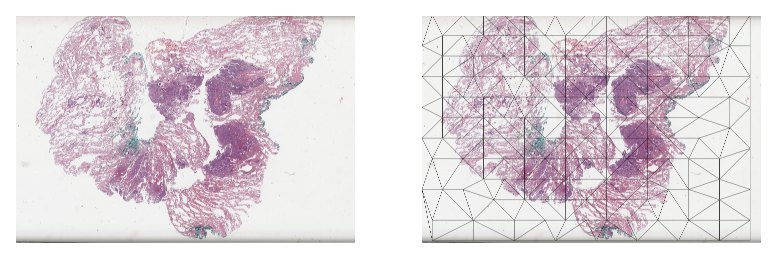

In [12]:
from skimage.exposure import equalize_hist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import Data

from tiatoolbox.utils.visualization import plot_graph
from tiatoolbox.wsicore.wsireader import get_wsireader

# !- debug injection, remove later
CACHE_PATH = f"{ROOT_OUTPUT_DIR}/features/"
WSI_DIR = "/home/dang/storage_1/dataset/TCGA-LUAD/"
wsi_paths = recur_find_ext(WSI_DIR, [".svs", ".ndpi"])[:2]
wsi_names = [pathlib.Path(v).stem for v in wsi_paths]
# !-

# we should use .read_json or sthg for this
sample_idx = 0
graph_path = f"{ROOT_OUTPUT_DIR}/graph/{wsi_names[sample_idx]}.json"
graph_dict = load_json(graph_path)
graph_dict = {k: np.array(v) for k, v in graph_dict.items()}
graph = Data(**graph_dict)

# deriving node colors via projecting n-d features down to 3-d
graph.x = StandardScaler().fit_transform(graph.x)
# .c for node colors
graph.c = PCA(n_components=3).fit_transform(graph.x)[:, [1, 0, 2]]
for channel in range(graph.c.shape[-1]):
    graph.c[:, channel] = (
        1 - equalize_hist(graph.c[:, channel]) ** 2
    )
graph.c = (graph.c * 255).astype(np.uint8)

reader = get_wsireader(wsi_paths[sample_idx])
thumb = reader.slide_thumbnail(4.0, 'mpp')
thumb_overlaid = plot_graph(
    thumb.copy(), graph.coords, graph.edge_index.T,
    node_colors=graph.c, node_size=5)
plt.subplot(1, 2, 1)
plt.imshow(thumb)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(thumb_overlaid)
plt.axis('off')
plt.show()

 # The Graph Neural Network

 ## The dataset loader
 As graph dataset that has yet been supported by the toolbox, we defined their
 loading and IO conversion here. The goal of this dataset class is to support
 parrallely loading the input concurrently from the running process on GPU.
 Commonly, it will also perform data conversion or any other preprocessing if
 necessary. In the scope of this notebook, we expose `preproc` argument to receive
 the function which will normalize node features.

In [13]:
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader


class SlideGraphDataset(Dataset):
    """Handling loading graph data from disk.

    Args:
        info_list (list): A list of `[path, label]` in case of
            `mode != "infer"`, otherwise it is a list of `path`.
            Here, `path` points to file containing the graph structure
            saved in `.json` while `label` is the label of the graph.
            The format within `.json` is expected to from
            `tiatoolbox.tools.graph`.
        mode (str): Denoting which data mode the `info_list` is in.
        preproc (callable): The prerocessing function for each node
            within the graph.

    """

    def __init__(self, info_list, mode="train", preproc=None):
        self.info_list = info_list
        self.mode = mode
        self.preproc = preproc

    def __getitem__(self, idx):
        info = self.info_list[idx]
        if any(v in self.mode for v in ['train', 'valid']):
            wsi_code, label = info
            # torch.Tensor will create 1-d vector not scalar
            label = torch.tensor(label)
        else:
            wsi_code = info

        with open(f"{GRAPH_DIR}/{wsi_code}.json", "r") as fptr:
            graph_dict = json.load(fptr)
        graph_dict = {k: np.array(v) for k, v in graph_dict.items()}

        if self.preproc is not None:
            graph_dict["x"] = self.preproc(graph_dict["x"])

        graph_dict = {k: torch.tensor(v) for k, v in graph_dict.items()}
        graph = Data(**graph_dict)

        if any(v in self.mode for v in ['train', 'valid']):
            return dict(graph=graph, label=label)
        return dict(graph=graph)

    def __len__(self):
        return len(self.info_list)

 ## Entire dataset feature normalization
 Similarly to how we utilize the stain normalizer, we define the feature
 normalizer here. Additionally, as this normalization is derived from the
 entire dataset population, we first load all the node features from all
 the graphs within our dataset and then training the normalizer. To avoid
 redundancy, we can also skip this training step and used an existing normalizer
 by setting `CACHE_PATH` to a valid path. By default, normalizer is trained and
 saved to `SCALER_PATH`.

In [14]:
import joblib
from sklearn.preprocessing import StandardScaler

CACHE_PATH = None
SCALER_PATH = f"{ROOT_OUTPUT_DIR}/node_scaler.dat"

# !- debug injection, remove later
# CACHE_PATH = None
# GRAPH_DIR = f"{ROOT_OUTPUT_DIR}/graph/"
# SCALER_PATH = f"{ROOT_OUTPUT_DIR}/node_scaler.dat"
# wsi_codes = recur_find_ext(GRAPH_DIR, ['.json'])
# wsi_codes = [pathlib.Path(v).stem for v in wsi_codes]

# CACHE_PATH = None
# GRAPH_DIR = f"/home/dang/local/workspace/projects/tiatoolbox/local/code/data/resnet/"
# SCALER_PATH = f"{ROOT_OUTPUT_DIR}/node_scaler.dat"
# wsi_codes = recur_find_ext(GRAPH_DIR, ['.json'])
# wsi_codes = [pathlib.Path(v).stem for v in wsi_codes]

CACHE_PATH = '/home/dang/storage_1/workspace/tiatoolbox/local/code/data/node_scaler.dat'
# !-

if CACHE_PATH and os.path.exists(CACHE_PATH):
    SCALER_PATH = CACHE_PATH  # assignment for follow up loading
    node_scaler = joblib.load(SCALER_PATH)
else:
    # ! we need a better way of doing this, will have OOM problem
    loader = SlideGraphDataset(wsi_codes, mode="infer")
    loader = DataLoader(
        loader,
        num_workers=8,
        batch_size=1,
        shuffle=False,
        drop_last=False
    )
    node_features = [
        v['graph'].x.numpy() for idx, v in enumerate(tqdm(loader))]
    node_features = np.concatenate(node_features, axis=0)
    node_scaler = StandardScaler(copy=False)
    node_scaler.fit(node_features)
    joblib.dump(node_scaler, SCALER_PATH)


# we must define the function after training
def nodes_preproc_func(node_features):
    return node_scaler.transform(node_features)


# exit()

 ## The architecture holder

In [15]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BatchNorm1d, Linear, ReLU
from torch_geometric.nn import (
    EdgeConv,
    GINConv,
    global_add_pool,
    global_max_pool,
    global_mean_pool,
)


class SlideGraphArch(nn.Module):
    def __init__(
        self,
        dim_features,
        dim_target,
        layers=[6, 6],
        pooling="max",
        dropout=0.0,
        conv="GINConv",
        gembed=False,
        **kwargs,
    ):
        super().__init__()
        self.dropout = dropout
        self.embeddings_dim = layers
        self.num_layers = len(self.embeddings_dim)
        self.nns = []
        self.convs = []
        self.linears = []
        self.pooling = {
            "max": global_max_pool,
            "mean": global_mean_pool,
            "add": global_add_pool,
        }[pooling]
        # if True then learn graph embedding for final classification
        # (classify pooled node features), otherwise pool node decision scores
        self.gembed = gembed

        conv_dict = {"GINConv": [GINConv, 1], "EdgeConv": [EdgeConv, 2]}
        if conv not in conv_dict:
            raise ValueError(f'Not support `conv="{conv}".')

        def create_linear(in_dims, out_dims):
            return nn.Sequential(
                Linear(in_dims, out_dims), BatchNorm1d(out_dims), ReLU()
            )

        input_emb_dim = dim_features
        out_emb_dim = self.embeddings_dim[0]
        self.first_h = create_linear(input_emb_dim, out_emb_dim)
        self.linears.append(Linear(out_emb_dim, dim_target))

        input_emb_dim = out_emb_dim
        for out_emb_dim in self.embeddings_dim[1:]:
            ConvClass, alpha = conv_dict[conv]
            subnet = create_linear(alpha * input_emb_dim, out_emb_dim)
            # ! this variable should be removed after training integrity checking
            self.nns.append(subnet)  # <--| as it already within ConvClass
            self.convs.append(ConvClass(self.nns[-1], **kwargs))
            self.linears.append(Linear(out_emb_dim, dim_target))
            input_emb_dim = out_emb_dim

        self.nns = torch.nn.ModuleList(self.nns)
        self.convs = torch.nn.ModuleList(self.convs)
        # has got one more for initial input, what does this mean
        self.linears = torch.nn.ModuleList(self.linears)

        # auxilary holder for external model, these are saved separately from torch.save
        # as they can be sklearn model etc.
        self.aux_model = {}

    def save(self, path, aux_path):
        state_dict = self.state_dict()
        torch.save(state_dict, path)
        joblib.dump(self.aux_model, aux_path)

    def load(self, path, aux_path):
        state_dict = torch.load(path)
        self.load_state_dict(state_dict)
        self.aux_model = joblib.load(aux_path)

    def forward(self, data):

        feature, edge_index, batch = data.x, data.edge_index, data.batch

        wsi_prediction = 0
        pooling = self.pooling
        node_prediction = 0

        feature = self.first_h(feature)
        for layer in range(self.num_layers):
            if layer == 0:
                node_prediction_sub = self.linears[layer](feature)
                node_prediction += node_prediction_sub
                node_pooled = pooling(node_prediction_sub, batch)
                wsi_prediction_sub = F.dropout(
                    node_pooled, p=self.dropout, training=self.training
                )
                wsi_prediction += wsi_prediction_sub
            else:
                feature = self.convs[layer - 1](feature, edge_index)
                if not self.gembed:
                    node_prediction_sub = self.linears[layer](feature)
                    node_prediction += node_prediction_sub
                    node_pooled = pooling(node_prediction_sub, batch)
                    wsi_prediction_sub = F.dropout(
                        node_pooled, p=self.dropout, training=self.training
                    )
                else:
                    node_pooled = pooling(feature, batch)
                    node_prediction_sub = self.linears[layer](node_pooled)
                    wsi_prediction_sub = F.dropout(
                        node_prediction_sub, p=self.dropout, training=self.training
                    )
                wsi_prediction += wsi_prediction_sub
        return wsi_prediction, node_prediction

    # running one single step
    @staticmethod
    def train_batch(model, batch_data, on_gpu, optimizer: torch.optim.Optimizer):
        wsi_graphs = batch_data["graph"].to("cuda")
        wsi_labels = batch_data["label"].to("cuda")

        # data type conversion
        wsi_graphs.x = wsi_graphs.x.type(torch.float32)

        # not RNN so does not accumulate
        optimizer.zero_grad()

        model.train()
        wsi_output, _ = model(wsi_graphs)

        # both expected to be Nx1
        wsi_labels_ = wsi_labels[:, None]
        wsi_labels_ = wsi_labels_ - wsi_labels_.T
        wsi_output_ = wsi_output - wsi_output.T
        diff = wsi_output_[wsi_labels_ > 0]
        loss = torch.mean(F.relu(1.0 - diff))
        # back prop and update
        loss.backward()
        optimizer.step()

        #
        loss = loss.detach().cpu().numpy()
        assert not np.isnan(loss)
        wsi_labels = wsi_labels.cpu().numpy()
        return [loss, wsi_output, wsi_labels]

    # running one single step
    @staticmethod
    def infer_batch(model, batch_data, on_gpu):
        wsi_graphs = batch_data["graph"].to("cuda")

        # data type conversion
        wsi_graphs.x = wsi_graphs.x.type(torch.float32)

        # Inference mode
        model.eval()
        # Do not compute the gradient (not training)
        with torch.inference_mode():
            wsi_output, _ = model(wsi_graphs)

        wsi_output = wsi_output.cpu().numpy()
        # Output should be a single tensor or scalar
        if "label" in batch_data:
            wsi_labels = batch_data["label"]
            wsi_labels = wsi_labels.cpu().numpy()
            return wsi_output, wsi_labels
        return [wsi_output]

 To test that our architecture works, at least on the surface level,
 we perform a brief inference with some random graph data and print
 out the output predictions.

In [16]:
# !- debug injection, remove later
GRAPH_DIR = f"/home/dang/storage_1/workspace/tiatoolbox/local/code/data/resnet"
SCALER_PATH = f"{ROOT_OUTPUT_DIR}/node_scaler.dat"
wsi_codes = recur_find_ext(GRAPH_DIR, ['.json'])
wsi_codes = [pathlib.Path(v).stem for v in wsi_codes][:2]
# !-


dummy_ds = SlideGraphDataset(wsi_codes, mode="infer")
loader = DataLoader(
    dummy_ds,
    num_workers=0,
    batch_size=8,
    shuffle=False,
)
iterator = iter(loader)
batch_data = iterator.__next__()

# data type conversion
wsi_graphs = batch_data["graph"]
wsi_graphs.x = wsi_graphs.x.type(torch.float32)

# define model object
arch_kwargs = dict(
    dim_features=2048,
    dim_target=1,
    layers=[16, 16, 8],
    dropout=0.5,
    pooling="mean",
    conv="EdgeConv",
    aggr="max",
)
model = SlideGraphArch(**arch_kwargs)

# inference section
model.eval()
with torch.inference_mode():
    output, _ = model(wsi_graphs)
    output = output.cpu().numpy()
print(output)

[[0.3033257 ]
 [0.34808403]]


 ## Batch Sampler
 Now that we have ensured that the model can run. Let's take a step back and
 looking at the model definition again so that we can prepare for the training
 and inference handling later.

 The `infer_batch` is straigh forward here, it handles inferencing of the input batch
 data and organizes the output content. Likewise, `train_batch` defines the handling
 for training, such as calculating the loss and so on. For our case, you can realize
 that the loss defined here is not straightforward or standardized like the
 cross-entropy.There is a pitfall that may crash the training if we do not handle
 this:
 ```python
 wsi_labels_ = wsi_labels[:, None]
 wsi_labels_ = wsi_labels_ - wsi_labels_.T
 wsi_output_ = wsi_output - wsi_output.T
 diff = wsi_output_[wsi_labels_ > 0]
 loss = torch.mean(F.relu(1.0 - diff))
 ```
 Specifically, we need to take care of `diff = wsi_output_[wsi_labels_ > 0]` where
 we only want to calculate the loss using pairing containing positive sample. Thus,
 when the batch contains no positive samples at all, especially for skewed dataset,
 there will no sample to calculate the loss and we will have `NaN` loss. To resolve
 this, we define a sampler dedicated for training process such that its resulting
 batch will always contain positive samples.

In [17]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Sampler


class StratifiedSampler(Sampler):
    """Sampling the dataset such that the batch contains stratified samples.

    Args:
        labels (list): List of labels, must be in the same ordering as input
            samples provided to the `SlideGraphDataset` object.
        batch_size (int): Size of the batch.
    Returns:
        List of indices to query from the `SlideGraphDataset` object.

    """

    def __init__(self, labels, batch_size=10):
        self.batch_size = batch_size
        self.num_splits = int(len(labels) / self.batch_size)
        self.labels = labels
        self.num_steps = self.num_splits

    def _sampling(self):
        # do we want to control randomness here
        skf = StratifiedKFold(n_splits=self.num_splits, shuffle=True)
        indices = np.arange(len(self.labels))  # idx holder
        # return array of arrays of indices in each batch
        return [tidx for _, tidx in skf.split(indices, self.labels)]

    def __iter__(self):
        return iter(self._sampling())

    def __len__(self):
        """The length of the sampler.

        This value actually corresponds to the number of steps to query
        sampled batch indices. Thus, to maintain epoch and steps hierarchy,
        this should be equal to the number of expected steps as in usual
        sampling: `steps=dataset_size / batch_size`.

        """
        return self.num_steps

 Here, you can notice the value is not between 0-1. For SlideGraph
 approach, we will turn the above values into proper propabilities later
 via using the Platt Scaling https://en.wikipedia.org/wiki/Platt_scaling.

 ## The running loop
 Training and running a neural network at the current time involve wiring
 several parts together so that they work in tandem. For training side,
 in a simplified term, it consists of:
 1. Define network object from a particular architecture.
 2. Define loader object to handle loading data concurrently.
 3. Define optimizer and scheduler to update network weights.
 4. The callbacks function at several junctions (starting of epoch, end of step, etc.)
 to aggregate results, saving the models, refreshing data, and much more.

 As for inference side, #3 is not necessary. At the moment, the wiring of these
 operations are handled mostly in the toolbox via various `engine` (controller).
 However, they focus mostly on inference portion. For SlideGraph case and this
 notebook, we also require the training portion. Hence, we define below a very
 simplified version of what an `engine` usually do for both `training` and `inference`.

 ### Helper functions and classes
Helper to clean up progress bar creation.
 * changing print char may break the bar so avoid it
Object to calculate running average.
 calculate the exponential moving average

 ### Defining the loop

In [18]:
from tiatoolbox.tools.scale import PlattScaling
from sklearn.metrics import average_precision_score as auprc_scorer
from sklearn.metrics import roc_auc_score as auroc_scorer


def run_once(
        dataset_dict, num_epochs, save_dir,
        on_gpu=True, pretrained=None,
        loader_kwargs={}, arch_kwargs={}, optim_kwargs={}):
    """Running the inference or training loop once."""
    model = SlideGraphArch(**arch_kwargs)
    if pretrained is not None:
        model.load(*pretrained)
    model = model.to("cuda")
    optimizer = torch.optim.Adam(model.parameters(), **optim_kwargs)

    # create the graph dataset holder for each subset info then
    # pipe them through torch/torch geometric specific loader
    # for loading in multi-thread
    loader_dict = {}
    for subset_name, subset in dataset_dict.items():
        _loader_kwargs = copy.deepcopy(loader_kwargs)
        batch_sampler = None
        if subset_name == 'train':
            _loader_kwargs = {}
            batch_sampler = StratifiedSampler(
                labels=[v[1] for v in subset],
                batch_size=loader_kwargs['batch_size']
            )

        ds = SlideGraphDataset(
            subset, mode=subset_name, preproc=nodes_preproc_func)
        loader_dict[subset_name] = DataLoader(
            ds,
            batch_sampler=batch_sampler,
            drop_last=subset_name == "train" and batch_sampler is None,
            shuffle=subset_name == "train" and batch_sampler is None,
            **_loader_kwargs,
        )

    for epoch in range(num_epochs):
        print(f"EPOCH {epoch:03d}")
        for loader_name, loader in loader_dict.items():
            # * EPOCH START
            step_output = []
            ema = ScalarMovingAverage()
            pbar = create_pbar(loader_name, len(loader))
            for step, batch_data in enumerate(loader):
                # * STEP COMPLETE CALLBACKS
                if loader_name == "train":
                    output = model.train_batch(model, batch_data, on_gpu, optimizer)
                    # check the output for agreement
                    ema({"loss": output[0]})
                    pbar.postfix[1]["step"] = output[0]
                    pbar.postfix[1]["EMA"] = ema.tracking_dict['loss']
                else:
                    output = model.infer_batch(model, batch_data, on_gpu)
                    batch_size = batch_data["graph"].num_graphs
                    # iterate over output head and retrieve
                    # each as N x item, each item may be of
                    # arbitrary dimensions
                    output = [np.split(v, batch_size, axis=0) for v in output]
                    # pairing such that it will be
                    # N batch size x H head list
                    output = list(zip(*output))
                    step_output.extend(output)
                pbar.update()
            pbar.close()

            # * EPOCH COMPLETE

            # callbacks to process output
            logging_dict = {}
            if loader_name == "train":
                for val_name, val in ema.tracking_dict.items():
                    logging_dict[f"train-EMA-{val_name}"] = val
            elif ("infer" in loader_name and
                    any(v in loader_name for v in ["train", "valid"])):
                # expand list of N dataset size x H heads
                # back to list of H Head each with N samples
                output = list(zip(*step_output))
                logit, true = output
                logit = np.squeeze(np.array(logit))
                true = np.squeeze(np.array(true))

                if "train" in loader_name:
                    scaler = PlattScaling()
                    scaler.fit(true, logit)
                    model.aux_model['scaler'] = scaler
                scaler = model.aux_model['scaler']
                prob = scaler.transform(logit)

                val = auroc_scorer(true, prob)
                logging_dict[f"{loader_name}-auroc"] = val
                val = auprc_scorer(true, prob)
                logging_dict[f"{loader_name}-auprc"] = val

            # callbacks for logging and saving
            for val_name, val in logging_dict.items():
                print(f"{val_name}: {val}")
            if "train" not in loader_dict:
                continue

            # track the statistics
            new_stats = {}
            if os.path.exists(f"{save_dir}/stats.json"):
                old_stats = load_json(f"{save_dir}/stats.json")
                # save a backup first
                save_as_json(logging_dict, f"{save_dir}/stats.old.json")
                new_stats = copy.deepcopy(old_stats)

            old_epoch_stats = {}
            if epoch in old_epoch_stats:
                old_epoch_stats = new_stats[epoch]
            old_epoch_stats.update(logging_dict)
            new_stats[epoch] = old_epoch_stats
            save_as_json(new_stats, f"{save_dir}/stats.json")

            # save the pytorch model
            model.save(
                f"{save_dir}/epoch={epoch:03d}.weights.pth",
                f"{save_dir}/epoch={epoch:03d}.aux.dat"
            )
    return step_output

 ## The training
 With the `engine` above, we can now start our training loop with
 a set of parameters.

In [19]:
# !- debug injection, remove later
GRAPH_DIR = f"/home/dang/local/workspace/projects/tiatoolbox/local/code/data/resnet/"
SCALER_PATH = f"{ROOT_OUTPUT_DIR}/node_scaler.dat"
wsi_codes = label_df["WSI-CODE"].to_list()
# !-

loader_kwargs = dict(
    num_workers=8,
    batch_size=16,
)
arch_kwargs = dict(
    dim_features=2048,
    dim_target=1,
    layers=[16, 16, 8],
    dropout=0.5,
    pooling="mean",
    conv="EdgeConv",
    aggr="max",
)
optim_kwargs = dict(
    lr=1.0e-3,
    weight_decay=1.0e-4,
)
NUM_EPOCHS = 5

MODEL_DIR = f"{ROOT_OUTPUT_DIR}/model/"
for split_idx, split in enumerate(split_list):
    break
    new_split = {
        "train": split['train'],
        "infer-train": split['train'],
        "infer-valid": split['valid']
    }
    split_save_dir = f"{MODEL_DIR}/{split_idx:02d}/"
    rm_n_mkdir(split_save_dir)
    run_once(
        new_split, NUM_EPOCHS,
        save_dir=split_save_dir,
        arch_kwargs=arch_kwargs,
        loader_kwargs=loader_kwargs,
        optim_kwargs=optim_kwargs)

 ## The inference

 ### The model selections
 According to our engine running loop definition above, these
 are the metrics saved for each epoch:
 - "infer-train-auroc"
 - "infer-train-auprc"
 - "infer-valid-auroc"
 - "infer-valid-auprc"

In [20]:
PRETRAINED_DIR = f"{ROOT_OUTPUT_DIR}/model/"
stat_files = recur_find_ext(PRETRAINED_DIR, [".json"])
stat_files = [v for v in stat_files if ".old.json" not in v]


def select_checkpoints(
        stat_file_path: str,
        top_k: int = 2,
        metric: str = "infer-valid-auprc"):
    """Select checkpoints basing on training statistics.

    Args:
        stat_file_path (str): Path pointing to the .json
            which contains the statistics.
        top_k (int): Number of top checkpoints to be selected.
        metric (str): The metric name saved within .json to perform
            selection.
    Returns:
        paths (list): List of paths or info tuple where each point
            to the correspond check point saving location.
        stats (list): List of corresponding statistics.

    """
    stats_dict = load_json(stat_file_path)
    # k is the epoch counter in this case
    stats = [[int(k), v[metric]] for k, v in stats_dict.items()]
    # sort epoch ranking from largest to smallest
    stats = sorted(stats, key=lambda v: v[1], reverse=True)
    chkpt_stats_list = stats[:top_k]  # select top_k

    model_dir = pathlib.Path(stat_file_path).parent
    epochs = [v[0] for v in chkpt_stats_list]
    paths = [(
        f"{model_dir}/epoch={epoch:03d}.weights.pth",
        f"{model_dir}/epoch={epoch:03d}.aux.dat")
        for epoch in epochs
    ]
    return paths, chkpt_stats_list


chkpts, chkpt_stats_list = select_checkpoints(stat_files[0])

 ### Bulk inference and ensemble results

In [21]:
# !- injecttion debug
split_list = split_list[:1]
# !-

loader_kwargs = dict(
    num_workers=8,
    batch_size=16,
)
arch_kwargs = dict(
    dim_features=2048,
    dim_target=1,
    layers=[16, 16, 8],
    dropout=0.5,
    pooling="mean",
    conv="EdgeConv",
    aggr="max",
)

cum_stats = []
for split_idx, split in enumerate(split_list):
    break
    new_split = {
        "infer": [v[0] for v in split["test"]]
    }

    # Perform ensembling by averaging probabilities
    # across checkpoint predictions
    cum_results = []
    for chkpt_info in chkpts:
        chkpt_results = run_once(
            new_split,
            num_epochs=1,
            save_dir=None,
            pretrained=chkpt_info,
            arch_kwargs=arch_kwargs,
            loader_kwargs=loader_kwargs,
        )

        # * re-calibrate logit to probabilities
        model = SlideGraphArch(**arch_kwargs)
        model.load(*chkpt_info)
        scaler = model.aux_model['scaler']
        chkpt_results = np.array(chkpt_results)
        chkpt_results = np.squeeze(chkpt_results)
        chkpt_results = scaler.transform(chkpt_results)

        cum_results.append(chkpt_results)
    cum_results = np.array(cum_results)
    cum_results = np.squeeze(cum_results)
    prob = np.mean(cum_results, axis=0)

    # * calculate split statistics
    true = [v[1] for v in split["test"]]
    true = np.array(true)

    cum_stats.append({
        'auroc': auroc_scorer(true, prob),
        'auprc': auprc_scorer(true, prob)
    })

stat_df = pd.DataFrame(cum_stats)
for metric in stat_df.columns:
    vals = stat_df[metric]
    mu = np.mean(vals)
    va = np.std(vals)
    print(f'{metric}: {mu:0.4f}±{va:0.4f}')